In [ ]:
!pip install py7zr
!pip install lightfm


# Рекомендательная система

In [ ]:
import os
import py7zr

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Скачивание данных и feature engineering
Скачиваем и разархивируем файлы с данными

In [ ]:
# directory = "..\music_recsys\kkbox-music-recommendation-challenge"

# for filename in os.listdir(directory):
#     if filename.endswith(".7z"):
#         file_path = os.path.join(directory, filename)
#         extract_dir = os.path.splitext(file_path)[0]
#         os.makedirs(extract_dir, exist_ok=True)
#         with py7zr.SevenZipFile(file_path, mode='r') as archive:
#             archive.extractall(path=extract_dir)
#         print(f"Extracted {filename} to {extract_dir}")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Загрузка данных

In [5]:
train = pd.read_csv("/content/drive/MyDrive/music_recsys/train.csv")
test = pd.read_csv("/content/drive/MyDrive/music_recsys/test.csv")

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 6 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   msno                object
 1   song_id             object
 2   source_system_tab   object
 3   source_screen_name  object
 4   source_type         object
 5   target              int64 
dtypes: int64(1), object(5)
memory usage: 337.7+ MB


### Interactions

Убедимся в том, что дубликатов в данных нет

In [ ]:
train.duplicated(subset=['msno', 'song_id'], keep=False).sum()

0

In [ ]:
test.duplicated(subset=['msno', 'song_id'], keep=False).sum()

0

Оставим только данные, связанные непосредственно со взаимодействиями пользователей

In [ ]:
interaction_features = ['msno', 'song_id']
train = train[interaction_features]
test = test[interaction_features]

### Songs

In [ ]:
songs = pd.read_csv("/content/drive/MyDrive/music_recsys/songs.csv")

In [ ]:
songs.head(3)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0


In [ ]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2296320 entries, 0 to 2296319
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   song_id      object 
 1   song_length  int64  
 2   genre_ids    object 
 3   artist_name  object 
 4   composer     object 
 5   lyricist     object 
 6   language     float64
dtypes: float64(1), int64(1), object(5)
memory usage: 122.6+ MB


In [ ]:
songs.nunique()

song_id        2296320
song_length     146534
genre_ids         1045
artist_name     222363
composer        329822
lyricist        110924
language            10
dtype: int64

In [ ]:
songs['language'].value_counts()

language
 52.0    1336694
-1.0      639467
 3.0      106295
 17.0      92518
 24.0      41744
 31.0      39201
 10.0      15482
 45.0      14435
 59.0       8098
 38.0       2385
Name: count, dtype: int64

In [ ]:
songs['language'].fillna(52, inplace=True)

In [ ]:
songs['language'] = songs['language'].astype(str)

In [ ]:
def count_genres(n):
  n = str(n)
  return len(n.split('|'))
songs['num_genres'] = songs['genre_ids'].apply(count_genres)

In [ ]:
songs['genre_ids'] = songs['genre_ids'].fillna('genre_unknown').astype(str)

In [ ]:
songs['artist_name'] = songs['artist_name'].fillna('artist_unknown').str.lower()
songs['lyrycist'] = songs['lyricist'].fillna('lyricist_unknown').str.lower()
songs['composer'] = songs['composer'].fillna('composer_unknown').str.lower()

Длина песни слабо характеризует предпочтения пользователей, лучше избавиться от этого признака

In [ ]:
songs = songs[['song_id', 'genre_ids', 'artist_name', 'composer', 'lyrycist', 'language']]

In [ ]:
songs.head()

,song_id,genre_ids,artist_name,composer,lyrycist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,465,張信哲 (jeff chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,444,blackpink,teddy| future bounce| bekuh boom,teddy,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,465,super junior,composer_unknown,lyricist_unknown,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,465,s.h.e,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,726,貴族精選,traditional,traditional,52.0


### Members

In [ ]:
members = pd.read_csv("/content/drive/MyDrive/music_recsys/members.csv")

Предпочтения различаются у разных поколений, чтобы снизить кол-во признаков разделим возраст по поколениям

In [ ]:
def get_age(n):
  if n < 10: return '0_10'
  elif 10 <= n < 20: return '10_20'
  elif 20 <= n < 30: return '20_30'
  elif 30 <= n < 40: return '30_40'
  elif 40 <= n < 50: return '40_50'
  elif 50 <= n < 60: return '50_60'
  else: return '60+'

members['bd'] = members['bd'].apply(int).apply(get_age)

In [ ]:
def get_sex(n):
  if n == 'male': return n
  elif n == 'female': return n
  return 'sex_unknown'

members['gender'] = members['gender'].apply(get_sex)

In [ ]:
members['city'] = members['city'].astype(str)

Оставим признаки, которые могут влиять на предпочтения пользователей

In [ ]:
members = members[['msno', 'city', 'bd', 'gender']]

In [ ]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34403 entries, 0 to 34402
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   msno    34403 non-null  object
 1   city    34403 non-null  object
 2   bd      34403 non-null  object
 3   gender  34403 non-null  object
dtypes: object(4)
memory usage: 1.1+ MB


In [ ]:
interaction_users = train['msno'].unique()

common_users = len(np.intersect1d(interaction_users, members['msno']))
users_only_in_interaction = len(np.setdiff1d(interaction_users, members['msno']))
users_only_features = len(np.setdiff1d(members['msno'], interaction_users))
total_users = common_users + users_only_in_interaction + users_only_features
print(f'Кол-во пользователей - {total_users}')
print(f'Кол-во пользователей c взаимодействиями и фичами - {common_users} ({common_users / total_users * 100:.2f}%)')
print(f'Кол-во пользователей только c взаимодействиями - {users_only_in_interaction} ({users_only_in_interaction / total_users * 100:.2f}%)')
print(f'Кол-во пользователей только c фичами - {users_only_features} ({users_only_features / total_users * 100:.2f}%)')

Кол-во пользователей - 34403
Кол-во пользователей c взаимодействиями и фичами - 30755 (89.40%)
Кол-во пользователей только c взаимодействиями - 0 (0.00%)
Кол-во пользователей только c фичами - 3648 (10.60%)


In [ ]:
interaction_users = test['msno'].unique()

common_users = len(np.intersect1d(interaction_users, members['msno']))
users_only_in_interaction = len(np.setdiff1d(interaction_users, members['msno']))
users_only_features = len(np.setdiff1d(members['msno'], interaction_users))
total_users = common_users + users_only_in_interaction + users_only_features
print(f'Кол-во пользователей - {total_users}')
print(f'Кол-во пользователей c взаимодействиями и фичами - {common_users} ({common_users / total_users * 100:.2f}%)')
print(f'Кол-во пользователей только c взаимодействиями - {users_only_in_interaction} ({users_only_in_interaction / total_users * 100:.2f}%)')
print(f'Кол-во пользователей только c фичами - {users_only_features} ({users_only_features / total_users * 100:.2f}%)')

Кол-во пользователей - 34403
Кол-во пользователей c взаимодействиями и фичами - 25131 (73.05%)
Кол-во пользователей только c взаимодействиями - 0 (0.00%)
Кол-во пользователей только c фичами - 9272 (26.95%)


## EDA

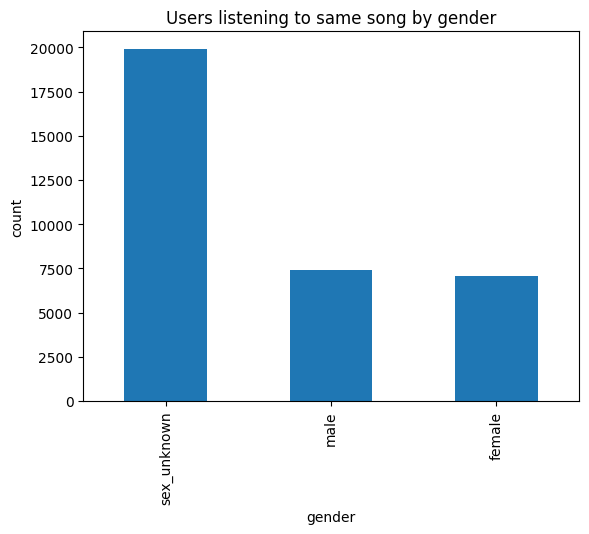

In [ ]:
members.gender.value_counts(dropna=False).plot(kind='bar')
plt.title('Users listening to same song by gender')
plt.xlabel('gender')
plt.ylabel("count")
plt.show()

У большого количества пользователей возраст не известен, но среди известных кол-во мужчин и женщин примерно равно

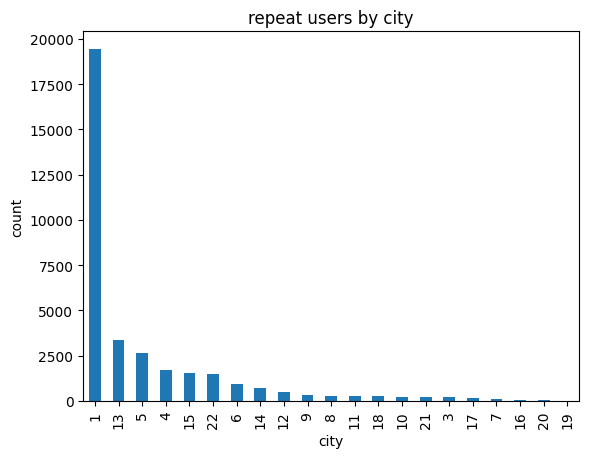

In [ ]:
members.city.value_counts().plot(kind='bar')
plt.title('repeat users by city')
plt.xlabel('city')
plt.ylabel('count')
plt.show()

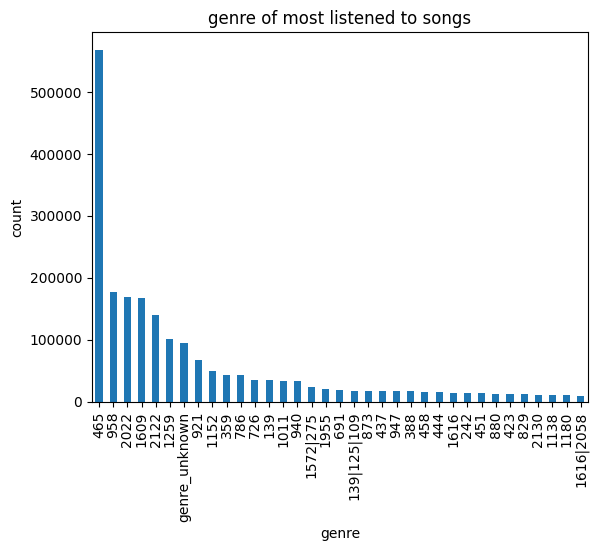

In [ ]:
songs.genre_ids.value_counts()[:35].plot(kind='bar')
plt.title('genre of most listened to songs')
plt.xlabel('genre')
plt.ylabel('count')
plt.show()

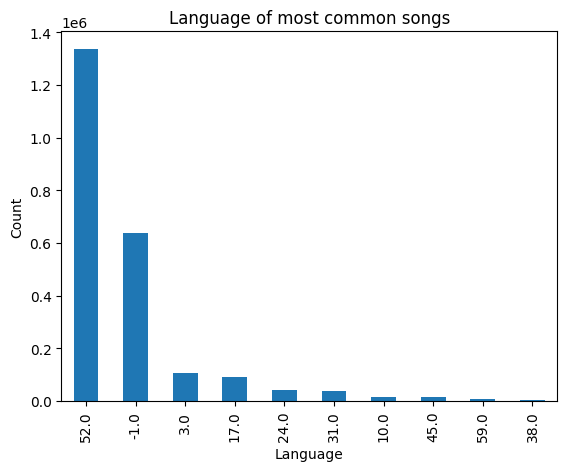

In [ ]:
songs.language.value_counts().plot(kind='bar')
plt.title('Language of most common songs')
plt.ylabel('Count')
plt.xlabel('Language')
plt.show()

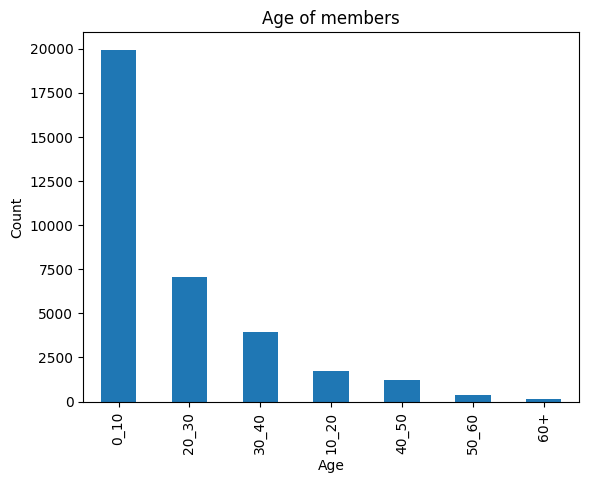

In [ ]:
members.bd.value_counts().plot(kind='bar')
plt.title('Age of members')
plt.ylabel('Count')
plt.xlabel('Age')
plt.show()

Видим аномальное значение в столбце 0_10.
Это может быть связано с ошибочным вводом возраста пользователями или сбоем в данных

## Построение модели

Перейдем к построению модели. Я остановил сво выбор на LightFM
Гибридный подход:
### Основные преимущества алгоритма LightFM:

1. **Гибридный подход**:
   - LightFM может использовать как коллаборативные (поведение пользователей), так и контентные данные (свойства объектов и пользователей), что позволяет делать рекомендации даже в случае холодного старта, когда о пользователе или объекте мало информации.

2. **Эффективность при разреженных данных**:
   - Модель хорошо работает с большими, разреженными наборами данных, что часто встречается в рекомендательных системах, где многие пользователи взаимодействуют только с ограниченным количеством объектов.

3. **Масштабируемость**:
   - Алгоритм спроектирован таким образом, чтобы быть масштабируемым и эффективно работать на больших наборах данных, используя многопоточность для ускорения вычислений.

4. **Поддержка различных функций потерь**:
   - LightFM поддерживает несколько функций потерь, включая логистическую регрессию, BPR (Bayesian Personalised Ranking) и WARP (Weighted Approximate-Rank Pairwise), что делает его гибким в выборе метода оптимизации в зависимости от конкретных задач.

5. **Поддержка пользовательских и объектных признаков**:
   - Модель может интегрировать дополнительные признаки для пользователей и объектов (например, возраст пользователя, жанр фильма), улучшая качество рекомендаций.

6. **Воспроизводимость результатов**:
   - LightFM позволяет установить `random_state`, обеспечивающий воспроизводимость результатов при экспериментах и тестировании.

7. **Простота использования**:
   - Библиотека LightFM предоставляет простой и интуитивно понятный API, который упрощает создание, обучение и применение рекомендательных моделей.

8. **Разнообразие рекомендаций**:
   - Функция потерь WARP эффективно работает на задачах, где важно не просто предсказать наиболее релевантные объекты, но и обеспечить разнообразие в рекомендациях.



Создадим списки признаков для пользователей и песен

In [ ]:
user_features = list(members['gender'].unique()) + list(members['city'].unique()) + list(members['bd'].unique())

In [ ]:
item_features = list(songs['genre_ids'].str.split('|').explode().unique()) + list(songs['composer'].str.split('|').explode().unique()) + list(songs['lyrycist'].str.split('|').explode().unique()) + list(songs['artist_name'].str.split('|').explode().unique()) + list(songs['language'].unique())

In [ ]:
from lightfm.data import Dataset
from lightfm import LightFM

In [ ]:
dataset = Dataset()

In [ ]:
dataset.fit(
    users=pd.concat([train['msno'], test['msno']]).unique(),
    user_features=user_features,
    items=pd.concat([train['song_id'], test['song_id']]).unique(),
    item_features=item_features
)

In [ ]:
num_users, num_items = dataset.interactions_shape()
num_users, num_items

(34403, 419839)

In [ ]:
lightfm_mapping = dataset.mapping()
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'user_features_mapping': lightfm_mapping[1],
    'items_mapping': lightfm_mapping[2],
    'item_features_mapping': lightfm_mapping[3],
}
print('users_mapping len - ', len(lightfm_mapping['users_mapping']))
print('user_features_mapping len - ', len(lightfm_mapping['user_features_mapping']))
print('items_mapping len - ', len(lightfm_mapping['items_mapping']))
print('Users item_features_mapping len - ', len(lightfm_mapping['item_features_mapping']))

users_mapping len -  34403
user_features_mapping len -  34434
items_mapping len -  419839
Users item_features_mapping len -  1001985


In [ ]:
lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

In [ ]:
num_user_features = dataset.user_features_shape()
num_show_features = dataset.item_features_shape()
print('Num user features: {} -> {}\nnum item features: {} -> {}.'.format(
    num_user_features[1] - num_users, num_user_features[1],
    num_show_features[1] - num_items, num_show_features[1]))

Num user features: 31 -> 34434
num item features: 582146 -> 1001985.


In [ ]:
def df_to_tuple_iterator(df):
    return zip(*df.values.T)

def concat_last_to_list(t):
    return (t[0], list(t[1:])[0])

def df_to_tuple_list_iterator(df):
    return map(concat_last_to_list, zip(*df.values.T))

In [ ]:
train_mat, train_mat_weights = dataset.build_interactions(df_to_tuple_iterator(train[['msno', 'song_id']]))
train_mat

<34403x419839 sparse matrix of type '<class 'numpy.int32'>'
	with 7377418 stored elements in COOrdinate format>

In [ ]:
train_mat_weights

<34403x419839 sparse matrix of type '<class 'numpy.float32'>'
	with 7377418 stored elements in COOrdinate format>

In [ ]:
members['features'] = members[['bd', 'gender', 'city']].astype(str).apply(lambda x: list(x), axis=1)
members.head()

,msno,city,bd,gender,features
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0_10,sex_unknown,"[0_10, sex_unknown, 1]"
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0_10,sex_unknown,"[0_10, sex_unknown, 1]"
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0_10,sex_unknown,"[0_10, sex_unknown, 1]"
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0_10,sex_unknown,"[0_10, sex_unknown, 1]"
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0_10,sex_unknown,"[0_10, sex_unknown, 1]"


In [ ]:
known_users_filter = members['msno'].isin(train['msno'].unique())

In [ ]:
train_user_features = dataset.build_user_features(
    df_to_tuple_list_iterator(
        members.loc[known_users_filter, ['msno', 'features']]
    )
)
train_user_features

<34403x34434 sparse matrix of type '<class 'numpy.float32'>'
	with 126668 stored elements in Compressed Sparse Row format>

In [ ]:
songs['features'] = songs[['genre_ids', 'language', 'artist_name', 'composer', 'lyrycist']].apply(lambda x: [str(i) for el in x for i in el.split('|') ], axis=1)

In [ ]:
known_items_filter = songs['song_id'].isin(train['song_id'].unique())
train_items_features = dataset.build_item_features(
    df_to_tuple_list_iterator(
        songs.loc[known_items_filter, ['song_id', 'features']]
    )
)
train_items_features

<419839x1001985 sparse matrix of type '<class 'numpy.float32'>'
	with 2330603 stored elements in Compressed Sparse Row format>

In [ ]:
lfm_model = LightFM(no_components=64, learning_rate=0.05, loss='warp', max_sampled=5, random_state=23)

### Обучение модели

In [ ]:
from tqdm.auto import tqdm

In [ ]:
num_epochs = 15
for _ in tqdm(range(num_epochs), total=num_epochs):
    lfm_model.fit_partial(
        train_mat,
        user_features=train_user_features,
        item_features=train_items_features,
        num_threads=4
    )

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
top_N = 20 # размер топа рекомендаций

In [ ]:
all_cols = list(lightfm_mapping['items_mapping'].values())

In [ ]:
item_titles = pd.Series(songs['genre_ids'].values, index=songs['song_id']).to_dict()

Предсказание на тесте

In [ ]:
recs = pd.DataFrame({
    'user_id': test['msno'].unique()
})

In [ ]:
def generate_lightfm_recs_mapper(model, item_ids, known_items, user_features, item_features, N, user_mapping, item_inv_mapping, num_threads=4):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.predict(user_id, item_ids, user_features=user_features, item_features=item_features, num_threads=num_threads)

        additional_N = len(known_items[user_id]) if user_id in known_items else 0
        total_N = N + additional_N
        top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]

        final_recs = [item_inv_mapping[item] for item in top_cols]
        if additional_N > 0:
            filter_items = known_items[user_id]
            final_recs = [item for item in final_recs if item not in filter_items]
        return final_recs[:N]
    return _recs_mapper

In [ ]:
known_items = train.groupby('msno')['song_id'].apply(list).to_dict()

In [ ]:
mapper = generate_lightfm_recs_mapper(
    lfm_model,
    item_ids=all_cols,
    known_items=known_items,
    N=top_N,
    user_features=train_user_features,
    item_features=train_items_features,
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=4
)

In [ ]:
recs['item_id'] = recs['user_id'].map(mapper)

In [13]:
def ndcg(df_true, df_pred, top_N):
    result = {}
    # Соединяем истинные данные и предсказания по индексам user_id и item_id
    test_recs = df_true.set_index(['user_id', 'item_id']).join(df_pred.set_index(['user_id', 'item_id']))
    test_recs = test_recs.sort_values(by=['user_id', 'rank'])

    # Рассчитываем количество элементов по пользователям и обратный ранг
    test_recs['users_item_count'] = test_recs.groupby(level='user_id')['rank'].transform(np.size)
    test_recs['reciprocal_rank'] = (1 / test_recs['rank']).fillna(0)

    # Считаем DCG@20
    test_recs['dcg'] = (1 / np.log2(test_recs['rank'] + 1)).where(test_recs['rank'] <= top_N, 0)

    # Группируем по пользователям и считаем DCG@20 для каждого пользователя
    dcg = test_recs.groupby('user_id')['dcg'].sum()

    # Сортируем данные для расчета идеального DCG
    test_recs['ideal_rank'] = test_recs.groupby('user_id')['rank'].rank(method='first', ascending=True)
    test_recs['idcg'] = (1 / np.log2(test_recs['ideal_rank'] + 1)).where(test_recs['ideal_rank'] <= top_N, 0)

    # Группируем по пользователям и считаем IDCG@20 для каждого пользователя
    idcg = test_recs.groupby('user_id')['idcg'].sum()

    # Вычисляем NDCG@20 для каждого пользователя и берем среднее
    ndcg = (dcg / idcg).fillna(0)
    result[f'NDCG@{top_N}'] = ndcg.mean()

    return pd.Series(result)


In [ ]:
recs = recs.explode('item_id')
recs['rank'] = recs.groupby('user_id').cumcount() + 1

Сохраним ответы модели и оценим качетсво

In [ ]:
path = '/content/drive/My Drive/predictions.csv'

# Сохранение в CSV
recs.to_csv(path, index=False)

In [8]:
test = test.rename(columns={'msno': 'user_id', 'song_id': 'item_id'})

### Финальный скор

In [3]:
recs = pd.read_csv("/content/drive/MyDrive/predictions.csv")

In [4]:
def compute_metrics(df_true, df_pred, top_N):
    result = {}
    test_recs = df_true.set_index(['user_id', 'item_id']).join(df_pred.set_index(['user_id', 'item_id']))
    test_recs = test_recs.sort_values(by=['user_id', 'rank'])

    test_recs['users_item_count'] = test_recs.groupby(level='user_id')['rank'].transform(np.size)
    test_recs['reciprocal_rank'] = (1 / test_recs['rank']).fillna(0)
    test_recs['cumulative_rank'] = test_recs.groupby(level='user_id').cumcount() + 1
    test_recs['cumulative_rank'] = test_recs['cumulative_rank'] / test_recs['rank']

    users_count = test_recs.index.get_level_values('user_id').nunique()
    for k in range(1, top_N + 1):
        hit_k = f'hit@{k}'
        test_recs[hit_k] = test_recs['rank'] <= k
        result[f'Precision@{k}'] = (test_recs[hit_k] / k).sum() / users_count
        result[f'Recall@{k}'] = (test_recs[hit_k] / test_recs['users_item_count']).sum() / users_count

    result[f'MAP@{top_N}'] = (test_recs["cumulative_rank"] / test_recs["users_item_count"]).sum() / users_count
    result[f'MRR'] = test_recs.groupby(level='user_id')['reciprocal_rank'].max().mean()
    return pd.Series(result)

In [19]:
metrics = compute_metrics(test,recs, 20)
metrics

Precision@1     0.087064
Recall@1        0.002635
Precision@2     0.080120
Recall@2        0.004207
Precision@3     0.076081
Recall@3        0.005449
Precision@4     0.073714
Recall@4        0.006683
Precision@5     0.072612
Recall@5        0.008059
Precision@6     0.071704
Recall@6        0.009326
Precision@7     0.070204
Recall@7        0.010380
Precision@8     0.069202
Recall@8        0.011482
Precision@9     0.068552
Recall@9        0.012867
Precision@10    0.067928
Recall@10       0.013975
Precision@11    0.067135
Recall@11       0.015018
Precision@12    0.066508
Recall@12       0.016025
Precision@13    0.065959
Recall@13       0.017146
Precision@14    0.065247
Recall@14       0.018079
Precision@15    0.064847
Recall@15       0.019131
Precision@16    0.064527
Recall@16       0.020073
Precision@17    0.064053
Recall@17       0.021032
Precision@18    0.063536
Recall@18       0.021924
Precision@19    0.063084
Recall@19       0.022950
Precision@20    0.062733
Recall@20       0.023908


In [20]:
metrics = ndcg(test, recs, 20)
metrics

NDCG@20    0.231028
dtype: float64

## Общий вывод

Система довольно хорошо справляется с выдачей релевантных песен с учетом их разнообразия. Значение NDCG является хорошим, но также показывает, что существует потенциал для модификации рекомендательной системы.